In [1]:
from os import listdir
import pandas as pd
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk import pos_tag
import re
import string
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from nltk.cluster.util import cosine_distance
import networkx as nx
import statistics


In [2]:
FINAL_CORPUS = './data/corpus/corpus_cleaned.pkl'
corpus = pd.read_pickle(FINAL_CORPUS)
corpus.sample(3)

,article,summary,article_char_count,article_word_count,article_sentence_count,summary_char_count,summary_word_count,summary_sentence_count
57106,"-- Season four of ""The Voice,"" featuring Ushe...",Usher and Shakira will filling in for Cee Lo G...,5262,968,57,184,35,3
20156,Akil Vohra quit a lucrative job in internation...,U.S. government started cracking down on Musli...,4057,646,36,217,29,3
40339,Aurora Ogg wakes up every day and goes to work...,Reince Priebus marks a year of changes at the ...,5489,924,50,299,47,4


In [3]:
PUNCTUATION_STOP = ['"', "'", '', '...', '!', '?', '(', ')', '[', ']', '{', '}', '\\', '/', ':', ',', '...',
               '$', '#', '%', '*', '%', '$', '#', '@', '--', '-', '_', '+', '=', '^', "''", '""', '','those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing', 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby', 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without', 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about', 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after', 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve']


In [4]:
def listToString(s):     
        str1 = " "  
        return (str1.join(s))


def preprocessing (text,tokenizer):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    # print(tokens)
    
    stripped=[]
    for x in tokens:
        if x not in PUNCTUATION_STOP:
            stripped.append(x)
    # print(stripped[:100])

    if tokenizer == 'lemma':
        token_list=[WordNetLemmatizer().lemmatize(word) for word in stripped]
    else:    
        porter = PorterStemmer()
        token_list = [porter.stem(word) for word in stripped]

    # print(stemmed[:100])

    return(listToString(token_list))

In [5]:

# Remove  punctuation/stopwords
def tokens_without_punctuation(text):
    tokens = word_tokenize(text)

    no_punctuation=[]
    for x in tokens:
        if x not in PUNCTUATION_STOP:
            no_punctuation.append(x)
    return no_punctuation

# Separates text into sentences
def  sentence_tokenize(text):
     sentence_tokenized = list()
     for txt in text.split('\n'):
          sentence_tokenized += sent_tokenize(txt)
     return sentence_tokenized

# words_list: list of words to be tokenized
# tokenizer: (string) can be 'lemma' or 'stem'
def _create_list_of_tokens(words_list, tokenizer):

     if tokenizer == 'lemma':
          token_maker = lambda word: WordNetLemmatizer().lemmatize(word).lower()
     else:
          token_maker = lambda word: PorterStemmer().stem(word).lower()
     token_list = list()

     for word in words_list:
          token = token_maker(word)
          if token not in PUNCTUATION_STOP:
               token_list.append(token)
     return token_list

In [6]:
# Extract word vectors
word_embeddings = {}
f = open('./glove/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()




In [7]:
def create_vector(sentence):
    v = sum([word_embeddings.get(w, np.zeros((100,))) for w in sentence])/(len(sentence)+0.001)
    return v

In [8]:
# Create vectors and calculate cosine similarity b/w two sentences
def sentence_similarity(sent1,sent2,method):
    if method=="glove":
        vector1 = create_vector(sent1)
        vector2 = create_vector(sent2)
        return 1-cosine_distance(vector1,vector2)
        
    else:
        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        for w in sent1:
            if not w in stopwords:
                vector1[all_words.index(w)]+=1

        for w in sent2:
            if not w in stopwords:
                vector2[all_words.index(w)]+=1

        return 1-cosine_distance(vector1,vector2)
    
        

In [9]:
# Create similarity matrix among all sentences
def build_similarity_matrix(sentences,method):
    similarity_matrix = np.zeros((len(sentences),len(sentences)))

    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1!=idx2:
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1],sentences[idx2],method)

    return similarity_matrix

In [17]:


#Function to split text into sentences by fullstop(.)
'''def read_article(text):

    article = text.split(". ")
    sentences =[]

    for sentence in article:
        print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]"," ").split(" "))

    return sentences'''

# Read the text and tokenize into sentences
def read_article(text):

    sentences =[]

    sentences = sent_tokenize(text)
    for sentence in sentences:
        sentence.replace("[^a-zA-Z0-9]"," ")

    return sentences







# Generate and return text summary
def generate_summary(text):

    method="glove"
    stop_words = stopwords.words('english')
    summarize_text = []
    summarize_text2 = []

    orig_sentences=sentence_tokenize(text)
    top_n=len(orig_sentences)//2
    # print(orig_sentences)
    # contents=preprocessing(text,"lemma")
    # print(contents)
    # sentences = sentence_tokenize(contents)
    # print(sentences)
    # senno=len(sentences)
    # Step1: read text and tokenize
    # sentences = read_article(text)
    
    orig_sentences=sentence_tokenize(text)
    sentence_similarity_matrix = build_similarity_matrix(orig_sentences,method)
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph,tol=1.0e-3)
    res=statistics.mean(list(scores.values()))

    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(orig_sentences)),reverse=True)

    for i in range(len(ranked_sentences)):
        if ranked_sentences[i][0] >=res:
            summarize_text.append(ranked_sentences[i][1])

    for i in range(top_n):
        summarize_text2.append(ranked_sentences[i][1])        

    # Step 6 : outpur the summarized version
    # print(len(orig_sentences))
    # print(len(summarize_text))

    str1 = " "
   
    # return string 
    return (str1.join(summarize_text2))
    # return " ".join(summarize_text)


In [20]:
# Generate and return text summary
def generate_summary2(text):

    method="normal"
    stop_words = stopwords.words('english')
    summarize_text = []
    summarize_text2 = []

    orig_sentences=sentence_tokenize(text)
    top_n=len(orig_sentences)//2
    # print(orig_sentences)
    # contents=preprocessing(text,"lemma")
    # print(contents)
    # sentences = sentence_tokenize(contents)
    # print(sentences)
    # senno=len(sentences)
    # Step1: read text and tokenize
    # sentences = read_article(text)

    # Steo2: generate similarity matrix across sentences
    sentence_similarity_matrix = build_similarity_matrix(orig_sentences,method)

    # Step3: Rank sentences in similarirty matrix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph,max_iter=10000)
    # print(scores)
    res=statistics.mean(list(scores.values()))
    # print(res)
    #Step4: sort the rank and place top sentences
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(orig_sentences)),reverse=True)
    # print(ranked_sentences)

    # Step 5: get the top n number of sentences based on rank
    for i in range(len(ranked_sentences)):
        if ranked_sentences[i][0] >=res:
            summarize_text.append(ranked_sentences[i][1])

    for i in range(top_n):
        summarize_text2.append(ranked_sentences[i][1])        

    # Step 6 : outpur the summarized version
    # print(len(orig_sentences))
    # print(len(summarize_text))

    str1 = " "
   
    # return string 
    return (str1.join(summarize_text2))
    # return " ".join(summarize_text)

In [12]:
article2="Rama is the titular protagonist and the first son of King Dasaratha.Though in this story Rama is a human, he's actually an avatar of the god Vishnu, who decided to take a human form in order to kill the evil rakshasa (demon) Ravana. Because of this, Rama's true identity is identifiable by his desire to rid the world of evil. He's exceptionally strong and skilled in battle, which is also an early clue to those around him that he's an incarnation of Vishnu. Rama uses this strength to string Shiva's bow and win Sita's hand in marriage. Though every citizen of Kosala wants Rama to be king, Rama demonstrates his intense loyalty and honor when he insists that Dasaratha uphold his promise to Kaikeyi, one of his wives, and crown Rama's brother, Bharatha, king instead.Rama retreats to the forests with Sita and his brother, Lakshmana, for 14 years, during which time Rama battles demons and rakshasas.When Ravana kidnaps Sita, Rama works closely with the monkeys of Kiskinda to rescue her.During the fight with Ravana, Rama behaves honorably by allowing Ravana time to recover from fainting spells, and even doubts the legitimacy and righteousness of his victory when he notices an injury on Ravana's back and fears that he inflicted it while Ravana fled.Though Rama has a streak of jealousy and possessiveness, especially when it comes to Sita (and even moreso in a later episode that is left out of this version of the epic), in general he is presented as the ideal hero and man. "
summary=generate_summary2(article2)
print(summary)

Though every citizen of Kosala wants Rama to be king, Rama demonstrates his intense loyalty and honor when he insists that Dasaratha uphold his promise to Kaikeyi, one of his wives, and crown Rama's brother, Bharatha, king instead.Rama retreats to the forests with Sita and his brother, Lakshmana, for 14 years, during which time Rama battles demons and rakshasas.When Ravana kidnaps Sita, Rama works closely with the monkeys of Kiskinda to rescue her.During the fight with Ravana, Rama behaves honorably by allowing Ravana time to recover from fainting spells, and even doubts the legitimacy and righteousness of his victory when he notices an injury on Ravana's back and fears that he inflicted it while Ravana fled.Though Rama has a streak of jealousy and possessiveness, especially when it comes to Sita (and even moreso in a later episode that is left out of this version of the epic), in general he is presented as the ideal hero and man. Rama is the titular protagonist and the first son of Ki

In [14]:
def nice_print(article, reference_summary, hypothesis_summary, width  = 300):
  dedented_text = lambda text: textwrap.dedent(text).strip()
  if article:
    print('ARTICLE')
    print(textwrap.fill(dedented_text(article), width=width), '\n')
  if reference_summary:
    print('REFERENCE SUMMARY: Summary from Dataset')
    print(textwrap.fill(dedented_text(reference_summary), width=width), '\n')
  if hypothesis_summary:
    print('HYPOTHESIS SUMMARY : Summary generated from Algorithm')
    print(textwrap.fill(dedented_text(hypothesis_summary), width=width), '\n')

In [21]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

# 12168,34861,87066,13950,40082,84878,87026
idxs=[12168,34861,87066,13950,40082,84878,87026]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = generate_summary2(article)
    # nice_print(article, reference_summary, hypothesis_summary)
    print(rouge_scoring(hypothesis_summary,reference_summary))

{'f': 0.14095238095238094, 'p': 0.07692307692307693, 'r': 0.8409090909090909}
{'f': 0.1818181818181818, 'p': 0.10648148148148148, 'r': 0.6216216216216216}
{'f': 0.34024896265560167, 'p': 0.21808510638297873, 'r': 0.7735849056603774}
{'f': 0.26666666666666666, 'p': 0.1651376146788991, 'r': 0.6923076923076923}
{'f': 0.1057142857142857, 'p': 0.05709876543209876, 'r': 0.7115384615384616}
{'f': 0.13564668769716087, 'p': 0.07375643224699828, 'r': 0.8431372549019608}
{'f': 0.14933333333333332, 'p': 0.08235294117647059, 'r': 0.8}


In [15]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

In [16]:
# idx = corpus.sample(1).index[0]
idx=69114
print(idx)
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = generate_summary(article)
nice_print(article, reference_summary, hypothesis_summary)




evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = 1,
                           limit_length = True,
                           length_limit = 100,
                           length_limit_type = 'words',
                           alpha = 0.5, # Default F1_score
                           stemming=True)

hypothesis = hypothesis_summary
reference = reference_summary

scores = evaluator.get_scores(hypothesis, reference)
print(scores) 

69114
ARTICLE
A blond girl found in Greece whose birth parents were traced to a Bulgarian Roma village will be cared for by a foster family when she's returned to Bulgaria, the government's social services agency said  Maria, as the girl was known by the Roma couple with whom she was living in central Greece, was
at the center of an international mystery after police discovered her.  DNA tests eventually showed that Saska Ruseva and her husband, Atanas Rusev, were her biological parents.  Her mother told CNN that she wants her child back -- but that seems unlikely to happen for now.  Maria, now being cared
for by Greek children's charity Smile of a Child, will instead be cared for by a foster family.  The parents and their nine children have been living in poverty in a tumbledown, one-room mud brick house in the village of Nikolaevo, in central Bulgaria.  Emil Todorov, director of the Children
Protection Department of Bulgaria's Agency for Social Assistance, told CNN it was not yet cle

In [17]:
idxs=[69114,65351]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = generate_summary(article)
    nice_print(article, reference_summary, hypothesis_summary)
    print(rouge_scoring(hypothesis_summary,reference_summary))

ARTICLE
A blond girl found in Greece whose birth parents were traced to a Bulgarian Roma village will be cared for by a foster family when she's returned to Bulgaria, the government's social services agency said  Maria, as the girl was known by the Roma couple with whom she was living in central Greece, was
at the center of an international mystery after police discovered her.  DNA tests eventually showed that Saska Ruseva and her husband, Atanas Rusev, were her biological parents.  Her mother told CNN that she wants her child back -- but that seems unlikely to happen for now.  Maria, now being cared
for by Greek children's charity Smile of a Child, will instead be cared for by a foster family.  The parents and their nine children have been living in poverty in a tumbledown, one-room mud brick house in the village of Nikolaevo, in central Bulgaria.  Emil Todorov, director of the Children
Protection Department of Bulgaria's Agency for Social Assistance, told CNN it was not yet clear wha

In [18]:
def run_on_corpus(df,n_predictions):

  t0 = time.time()
  sampling_interval = len(df) // n_predictions
  index = df.index[::sampling_interval][:n_predictions]
  data = df.loc[index, 'summary']
  predictions = pd.DataFrame( data = data.values , columns = ['reference'], index = index)
  

  predicted_column = str("Normal") + "_" + str("F1")
  print('Prediction colum: {}'.format(predicted_column))
  predictions.loc[index, predicted_column] = df.loc[index, 'article'].apply(generate_summary2)
  print('Time taken {:.2f} minutes'.format((time.time() - t0)/60))
              
    
  print()
  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return predictions




n_predictions = 200
predictions_test = run_on_corpus(corpus,n_predictions)

Prediction colum: Glove_F1
Time taken 1.45 minutes
Prediction colum: Normal_F1
Time taken 2.20 minutes

Total time to execute: 2.20 minutes


In [20]:
# predictions_test.to_pickle('./data/corpus/feature_score_1000.pkl')
# predictions_test=pd.read_pickle('./data/corpus/feature_score_1000.pkl')
predictions_test.sample(5)

,reference,Glove_F1,Normal_F1
80518,New social network for women claims to be 'tro...,"Now Karen Cahn, a former Google, YouTube, and ...",Karen Cahn: VProud is a digital safe space for...
80978,So You Think wins Prince of Wales Stakes at Ro...,Runner-up in this race last year to the ill-fa...,Runner-up in this race last year to the ill-fa...
19219,"Kunis joked on ""Jimmy Kimmel Live!"" about men ...",She then pulls out a microphone and begins a r...,She then pulls out a microphone and begins a r...
84637,"Obama found the speech ""outrageous and offens...",Delegates from the United States and other nat...,Delegates from the United States and other nat...
32479,Lance Cpl. Sara Castromata and Cpl. Jacob Wool...,It came as the Corps grieves another tragedy: ...,Wooley's awards include the Navy Meritorious U...


In [21]:
len(predictions_test)

200

In [22]:
def calculate_rouge(df, max_n = 1, alpha = 0.5, score = 'F1'):
  t0 = time.time()
  evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
  if score == 'F1':
    score_entry = 'f'
  elif score == 'Precision':
    score_entry = 'p'
  else:
    score == 'Recall'
    score_entry = 'r'
    
  scores_df = pd.DataFrame()
  for column in df.columns[1:]:
    score_column = column + '_' + score
    for idx in df.index:
      hypothesis = df.loc[idx, column]
      reference = df.loc[idx, 'reference']
      rouge_scores = evaluator.get_scores(hypothesis, reference)
      scores_df.loc[idx, score_column] = rouge_scores['rouge-' + str(max_n)][score_entry]

  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return scores_df

In [23]:
max_n = 1
alpha = 0.5 # Default F1_score
score = 'F1'
predictions_scores = calculate_rouge(predictions_test, max_n, alpha, score)

Total time to execute: 0.08 minutes


In [76]:
predictions_scores.max()

Glove_F1_F1     0.614173
Normal_F1_F1    0.614173
dtype: float64

In [75]:
predictions_scores.loc[[458]]

,Glove_F1_F1,Normal_F1_F1
458,0.257627,0.252632


In [69]:
np_df = predictions_scores.as_matrix()
np.df[458]

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

In [53]:
predictions_scores.mean()
# maxValueIndex = predictions_scores.idxmax()
# print(maxValueIndex)

Glove_F1_F1     0.163582
Normal_F1_F1    0.164661
dtype: float64

C:\Users\kk910\AppData\Local\Temp\ipykernel_10280\1083861212.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)


Text(0.5, 1.0, 'F1 score of ')

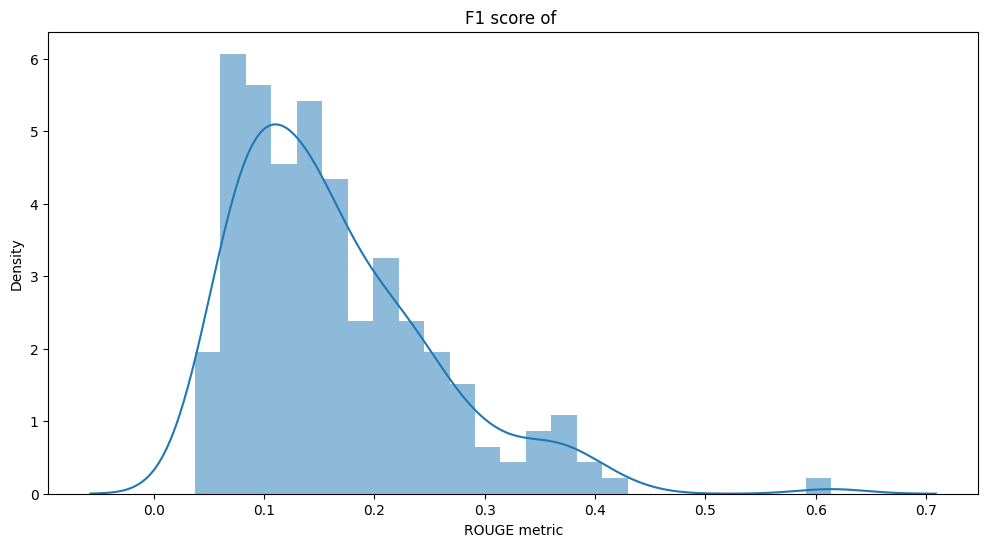

In [134]:
score_column = 'Normal_F1_F1'
# print('F1 average = {:.4f}'.format(predictions_scores[score_column].max()))
# print('F1 standard deviation = {:.4f}'.format(predictions_scores[score_column].std()))


_, ax = plt.subplots(figsize = (12,6))
sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)
ax.set_xlabel('ROUGE metric')
ax.set_title('F1 score of ')

In [57]:
def len_sent_tokenize(text):
  return len(sentence_tokenize(text))



qty_of_sentences = predictions_test['Glove_F1'].apply(len_sent_tokenize)

In [58]:
qty_of_sentences_reference = predictions_test['reference'].apply(len_sent_tokenize)

diff_number_of_sentences = qty_of_sentences - qty_of_sentences_reference

In [59]:
print(diff_number_of_sentences)
print("Max Difference",np.max(diff_number_of_sentences))
print("Minimum Difference",np.min(diff_number_of_sentences))

0        45
458       9
915       9
1373     39
1831      2
         ..
89210    11
89668     3
90128    46
90586     9
91044    10
Length: 200, dtype: int64
Max Difference 61
Minimum Difference 0


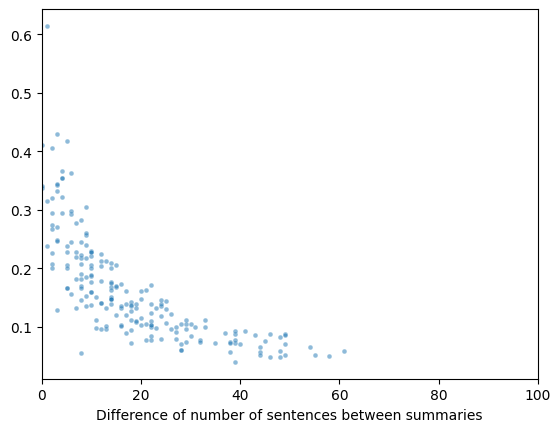

In [62]:
sns.scatterplot(x = diff_number_of_sentences, 
            y = predictions_scores['Glove_F1_F1'].values,
            alpha =0.5, s = 12)

plt.xlabel('Difference of number of sentences between summaries')
plt.xlim((0,+100))
plt.show()